In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os

# Initial EDA

In [2]:
load_dotenv()
DATA_PATH = os.getenv("DATA_PATH")

In [3]:
s_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_staticLimit.csv')

The two datasets differ in the way supply from the grid is limited. `s_data` contains static limit of 50kW, while `d_data` has a dynamic limit that changes over time. Perhaps to avoid higher loads on the grid at suboptimmaltimes of the day (when a lot of people use electricity)?

In [4]:
s_data["POWER_DEMAND"] = s_data["WALLBOX_1_POWER"] + s_data["WALLBOX_2_POWER"] + s_data["WALLBOX_3_POWER"] + s_data["WALLBOX_A_POWER"] + s_data["WALLBOX_B_POWER"] + s_data["WALLBOX_C_POWER"] + s_data["WALLBOX_FASTCHARGER_POWER"]
s_data["POWER_SUPPLY"] = s_data["GARAGE_EXTERNAL_POWER"] + s_data["PV_POWER"] + s_data["BATTERY_DISCHARGE_POWER"]

In [5]:
s_data.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,...,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,...,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066,15.242758,16.551039
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,...,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631,23.876519,24.569700
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,...,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000,0.147030,-23.178345
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,...,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472,0.197642,0.901735
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,...,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256,5.223808,5.885979
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,...,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050,15.560868,16.702183
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,...,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511,117.407838,129.619329


Sanity check above shows some potential anomalies:



    - What does negative external power mean?
    - One of the ground truth rules mentioned in the Danilo's email proposes SOC>80% to be one of the thresholds. There are no such instances in our dataset?
    - Does negative battery discharge power mean load on the grid? Should it be counted along with other power demands?
    - Also negative PV Power just doesn't make sense
    - What are wallbox energies?

In [5]:
#convert _time column into timestamp
s_data['_time'] = pd.to_datetime(s_data['_time'])

In [ ]:
""" 
Plotting the most interesting columns. One week of data is plotted.
"""
start_date = pd.to_datetime('2023-11-24').tz_localize('UTC')  # replace with your start date
end_date = start_date + pd.DateOffset(weeks=1)

interesting_columns = ["WALLBOX_1_POWER", "WALLBOX_2_POWER", "WALLBOX_3_POWER", "WALLBOX_A_POWER", "WALLBOX_B_POWER", "WALLBOX_C_POWER", "WALLBOX_FASTCHARGER_POWER", "GARAGE_EXTERNAL_POWER", "PV_POWER", "BATTERY_DISCHARGE_POWER", "POWER_DEMAND", "POWER_SUPPLY"]

week_data = s_data[(s_data['_time'] >= start_date) & (s_data['_time'] < end_date)]
for column in interesting_columns:
    week_data.plot(x='_time', y=column, legend=False)
    plt.xlabel('Time')
    plt.ylabel("Power [kW]")
    plt.title(column)


In [8]:
s_data["POWER_DEMAND_EXCEEDS_SUPPLY"] = s_data["POWER_DEMAND"] > s_data["POWER_SUPPLY"]
s_data["POWER_EXCEEDS_LIMIT"] = s_data["GARAGE_EXTERNAL_POWER"] > s_data["DEMAND_LIMIT"]
s_data["POWER_EXCEEDS_LIMIT"].value_counts()

POWER_EXCEEDS_LIMIT
False    54892
True      4550
Name: count, dtype: int64

I'm not sure what this is supposed to mean? What would cause supply/demand to diverge? Energy has to come from somewhere....

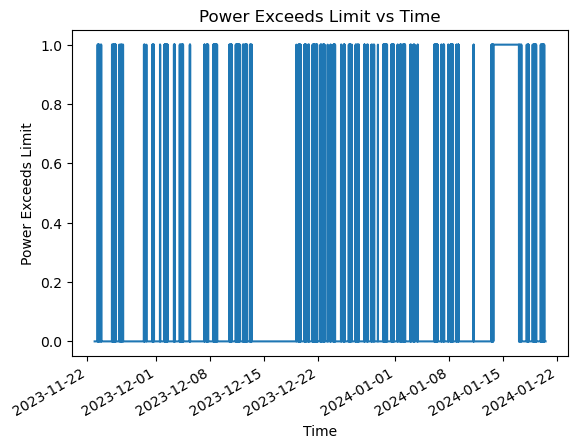

In [9]:
s_data["POWER_EXCEEDS_LIMIT"] = s_data["POWER_EXCEEDS_LIMIT"].astype(int)
s_data.plot(x='_time', y='POWER_EXCEEDS_LIMIT', legend=False)
plt.xlabel('Time')
plt.ylabel('Power Exceeds Limit')
plt.title('Power Exceeds Limit vs Time')
plt.show()

In [10]:
s_data[s_data["GARAGE_EXTERNAL_POWER"] > s_data["DEMAND_LIMIT"]].head()

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY,POWER_DEMAND_EXCEEDS_SUPPLY,POWER_EXCEEDS_LIMIT
516,2023-11-23 08:36:00+00:00,55.507824,50.0,1.0,40.0,54.463001,0.0,0.400391,3.604578,0.058594,...,0.143555,9.326246,0.177734,11.127154,0.718750,79.603340,111.504029,113.575403,False,1
517,2023-11-23 08:37:00+00:00,50.339851,50.0,1.0,38.0,58.232002,0.0,0.898438,3.857064,0.070312,...,0.160156,9.326246,0.189453,11.294097,1.335938,79.616318,111.715225,112.428917,False,1
518,2023-11-23 08:38:00+00:00,50.339851,50.0,1.0,38.0,58.516003,0.0,1.000000,3.914418,0.058594,...,0.151367,9.326246,0.195312,11.211280,1.328125,79.937515,111.963025,112.770272,False,1
519,2023-11-23 08:39:00+00:00,50.339851,50.0,1.0,38.0,58.928001,0.0,1.000000,3.963306,0.070312,...,0.168945,10.349286,0.179688,10.534795,1.343750,80.015213,112.354217,113.231159,False,1
520,2023-11-23 08:40:00+00:00,55.412121,50.0,1.0,38.0,58.006004,0.0,0.900391,3.318442,0.058594,...,0.173828,10.349286,0.166016,10.578958,1.265625,79.451141,111.764421,116.736567,False,1


In [11]:
s_data[(s_data["BATTERY_SOC"] < 40) & (s_data["GARAGE_EXTERNAL_POWER"]>60)].tail(15)


,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY,POWER_DEMAND_EXCEEDS_SUPPLY,POWER_EXCEEDS_LIMIT
34334,2023-12-26 03:04:00+00:00,76.275391,50.0,1.0,7.5,-1.223000,0.000000,0.000000,2.474727,0.046875,...,0.001953,0.010506,0.029297,1.585667,1.101562,65.131454,71.417696,77.527118,False,1
34335,2023-12-26 03:05:00+00:00,74.744141,50.0,1.0,7.5,-1.306000,0.000000,0.000000,2.640337,0.035156,...,0.000000,0.010506,0.029297,1.585667,1.085938,64.505280,70.774800,76.078478,False,1
34336,2023-12-26 03:06:00+00:00,73.691406,50.0,1.0,7.5,-1.307000,0.101562,0.000000,2.390340,0.046875,...,0.000000,0.010506,0.019531,1.547289,1.078125,63.280804,69.530708,74.774746,False,1
34337,2023-12-26 03:07:00+00:00,72.638680,50.0,1.0,7.5,-1.315000,0.000000,0.000000,1.901867,0.035156,...,0.000000,0.010506,0.029297,1.547289,1.039062,61.652546,67.890089,73.225546,False,1
34338,2023-12-26 03:08:00+00:00,70.054695,50.0,1.0,7.5,-1.275000,0.000000,0.000000,2.076975,0.035156,...,0.000000,0.010506,0.029297,1.588183,1.000000,59.247150,65.538151,70.856670,False,1
40537,2023-12-30 10:28:00+00:00,71.298836,50.0,1.0,38.0,-48.043003,0.902344,0.000000,1.572371,0.019531,...,0.000000,0.010352,0.000000,0.010311,0.007812,21.103186,21.149068,24.828204,False,1
42233,2023-12-31 14:44:00+00:00,60.484386,50.0,1.0,29.0,-12.346001,0.601562,0.000000,1.744424,0.023438,...,0.001953,0.010262,0.000000,0.010625,0.140625,35.471657,48.729931,49.882810,False,1
42432,2023-12-31 18:03:00+00:00,73.500008,50.0,1.0,34.0,39.407001,0.000000,0.500000,-0.002432,0.000000,...,0.000000,0.010262,0.000000,0.009957,1.304688,78.439156,78.487604,112.904577,False,1
45554,2024-01-02 22:06:00+00:00,60.005871,50.0,1.0,39.0,13.292001,0.000000,0.296875,1.677361,0.027344,...,0.000000,0.010405,0.000000,0.012254,1.015625,69.130653,74.162307,74.975233,False,1
47738,2024-01-06 10:30:00+00:00,70.820320,50.0,1.0,24.0,31.603001,0.000000,0.500000,-0.000987,0.000000,...,0.000000,0.010676,0.000000,0.010318,1.054688,78.217316,88.168338,102.422334,False,1


Obviously the ground truth rules aren't as "ground truth" as one might expect. There are several instances, where external power exceed twice the limit, and eventhough battery has enough charge, it doesn't help out as much as it could. It doesn't "shave the peak".

# Training a baseline model

`DecisionTreeClassifier` is trained on a chosen subset of features to predict when power drawn from the grid exceeds the static limit. Since the dataset is imbalanced, a naive classifier always predicts the majority class. Therefore, class weights are employed. max_depth=1 is used to avoid complexity.

In [12]:
features = s_data.drop(['POWER_EXCEEDS_LIMIT', '_time', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = s_data['POWER_EXCEEDS_LIMIT']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(random_state=42, max_depth=1, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.8635713684918832


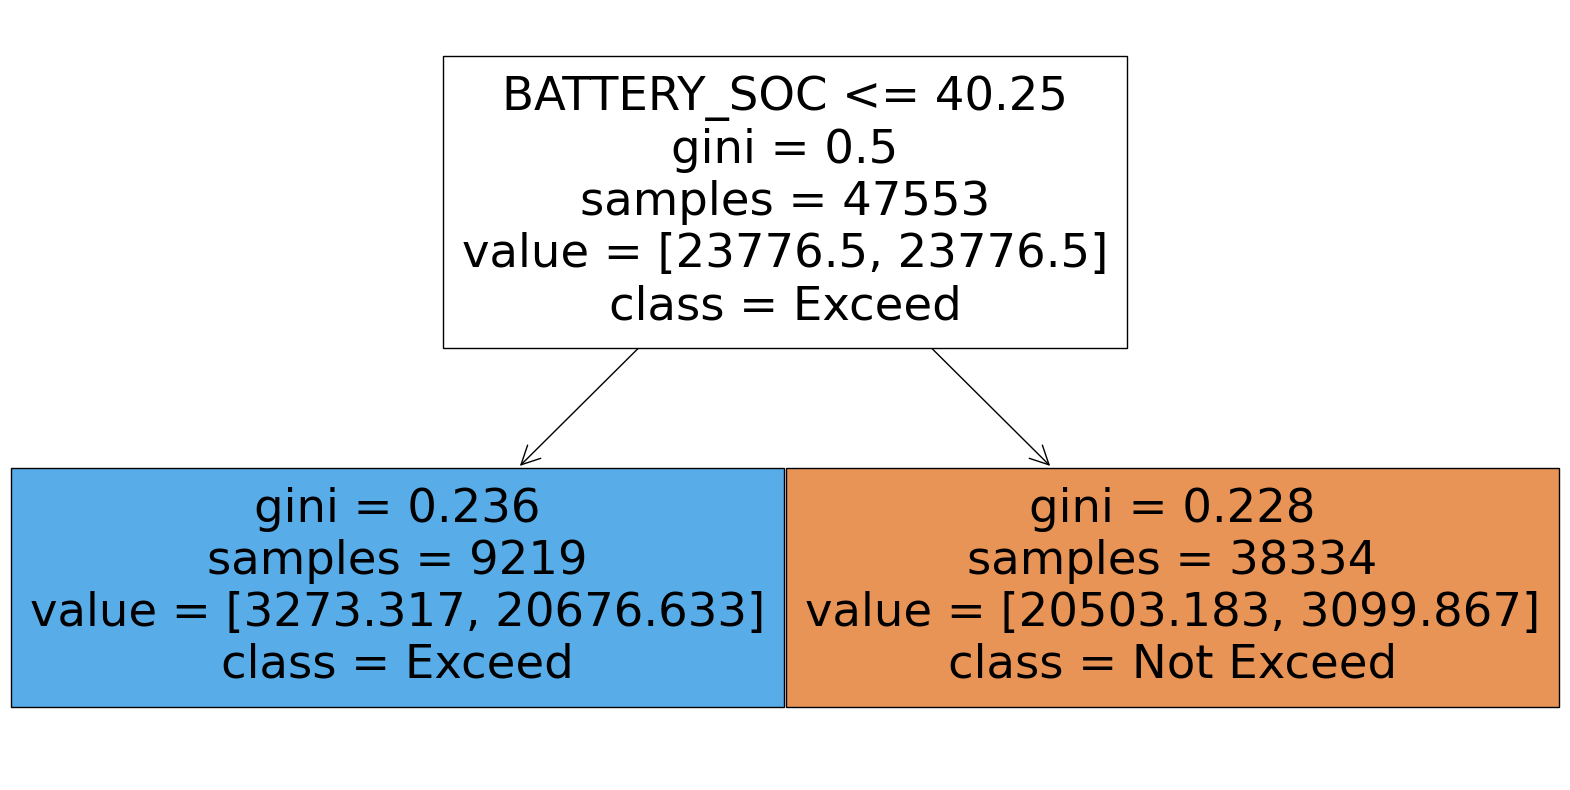

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  
plot_tree(clf, filled=True, feature_names=features.columns, class_names=['Not Exceed', 'Exceed'])
plt.show()

Awesome. That's the first ground truth rule extracted from the entire dataset.

# Ground truth reconstruction
As discovered during the initial EDA, some parts of the data don't follow ground truth rules mentionel in Danilo's email. The idea is to come up with a subset, that strictly follows the rules, and train a few baseline models that are able to extract ALL of the ground truth rules from that dataset. The model can then be tested onthe large dataset. Similarly should be done with a neuro-symbolic approach - LTNs?

The following are relevant ground truths (some are excluded, since they can't be extracted - see EDA section):

- 40% < SOC < 80%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
- SOC < 40%:
    - if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
    - If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
- SOC < 15%: Battery discharging is stopped due to battery health

First, we ONLY FOCUS ON STATIC LIMIT DATA.

`ISSUE:` In the second rule, how can we know when peak-shaving is happening? If GARAGE_EXTERNAL is <50, does that mean that battery discharge power should be 0? Should batteries only be utilized when GARAGE_EXTERNAL == 50? There are no instances where GARAGE_EXTERNAL is exactly 50.....

In [14]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = s_data[(s_data["BATTERY_SOC"]<=15) & (s_data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<50) & (s_data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = s_data[(s_data["BATTERY_SOC"]>15) &(s_data["BATTERY_SOC"]<40) & (s_data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=s_data["GARAGE_EXTERNAL_POWER"]) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = s_data[(s_data["BATTERY_SOC"]>=40) & (s_data["BATTERY_DISCHARGE_POWER"]>=0)]

In [15]:
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(s_data)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


In [16]:
# sort the data by BATTERY_SOC
df_GT = df_GT[df_GT["BATTERY_SOC"]>9].sort_values(by='BATTERY_SOC')
df_GT.head()

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER,POWER_DEMAND,POWER_SUPPLY,POWER_DEMAND_EXCEEDS_SUPPLY,POWER_EXCEEDS_LIMIT
50,2023-12-07 13:59:00+00:00,49.669930,50.0,1.0,9.5,-48.824001,0.800781,0.0,0.058205,0.000000,...,0.000000,0.010232,0.000000,0.010211,0.007812,0.171078,0.218500,0.904134,False,0
51,2023-12-07 14:00:00+00:00,49.765633,50.0,1.0,9.5,-48.817001,0.800781,0.0,0.066926,0.000000,...,0.000977,0.010232,0.000000,0.010211,0.000000,0.170808,0.218138,1.015557,False,0
128,2023-12-26 03:19:00+00:00,48.138691,50.0,1.0,9.5,-26.878002,0.398438,0.0,1.744000,0.023438,...,0.000000,0.010506,0.033203,2.293477,0.007812,0.138843,10.755640,23.004689,False,0
127,2023-12-26 03:18:00+00:00,46.990250,50.0,1.0,9.5,-26.903002,0.500000,0.0,1.733439,0.035156,...,0.000000,0.010506,0.029297,1.941506,0.000000,0.137770,10.396926,21.820687,False,0
52,2023-12-07 14:01:00+00:00,49.861336,50.0,1.0,10.0,-48.968002,0.800781,0.0,0.067676,0.000000,...,0.000000,0.010232,0.000000,0.010211,0.000000,0.150774,0.198315,0.961010,False,0


That's kinda yikes. Less than 20% of original dataset follows the ground-truth rules. Let's try anyways.

In [17]:
tree = DecisionTreeClassifier(random_state=42, max_depth=1, class_weight='balanced')
tree.fit(df_GT.drop(['POWER_EXCEEDS_LIMIT', '_time', 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'POWER_DEMAND', 'BATTERY_DISCHARGE_POWER'], axis=1), df_GT['POWER_EXCEEDS_LIMIT'])


DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=42)

[Text(0.5, 0.75, 'BATTERY_DISCHARGE_POWER <= 0.049\ngini = 0.5\nsamples = 9621\nvalue = [4810.5, 4810.5]\nclass = Not Exceed'),
 Text(0.25, 0.25, 'gini = 0.429\nsamples = 5743\nvalue = [2123.998, 4703.523]\nclass = Exceed'),
 Text(0.75, 0.25, 'gini = 0.074\nsamples = 3878\nvalue = [2686.502, 106.977]\nclass = Not Exceed')]

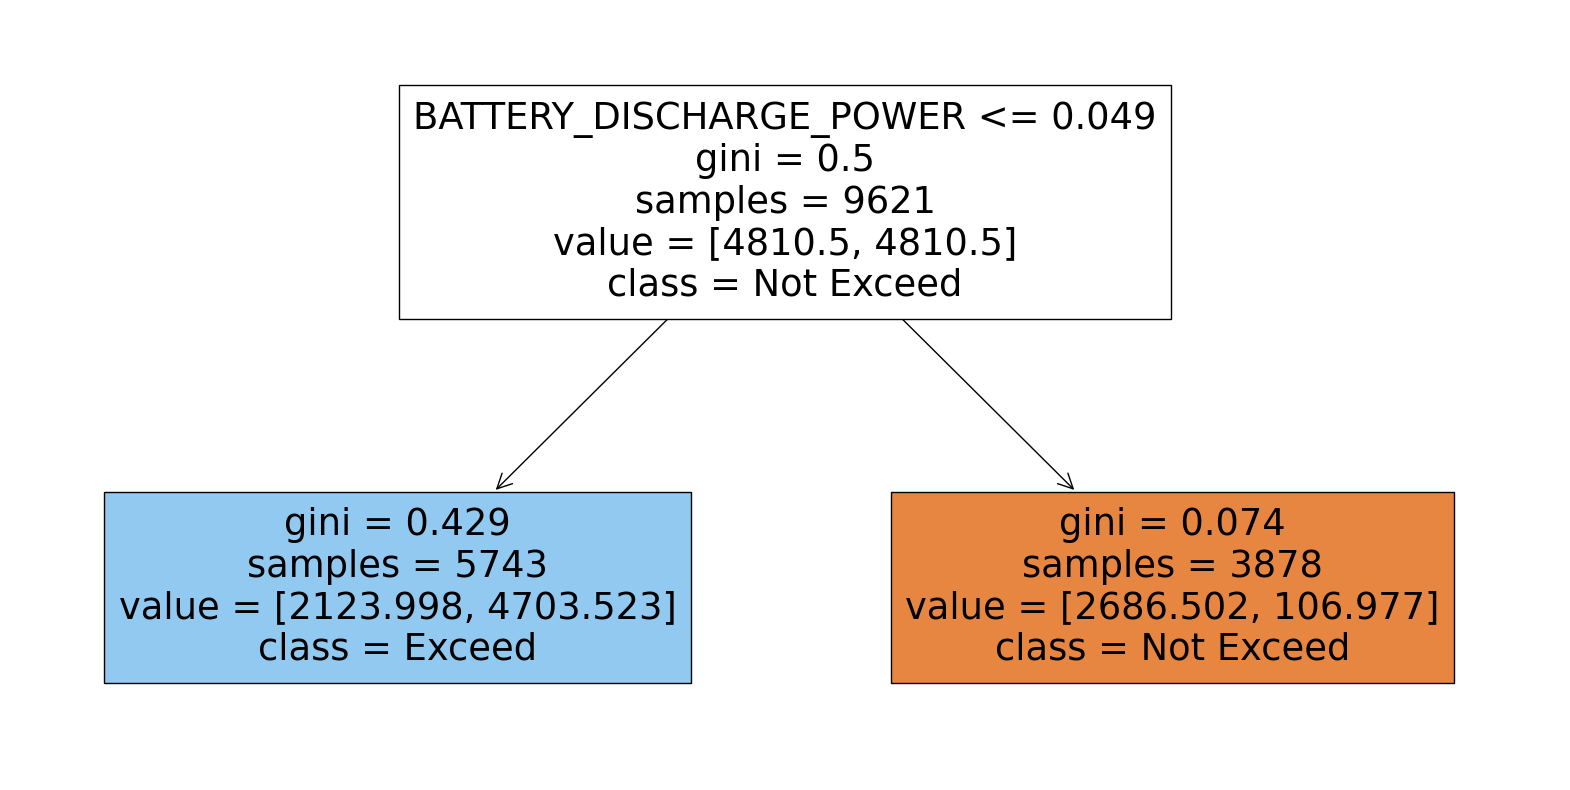

In [18]:
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=features.columns, class_names=['Not Exceed', 'Exceed'])

Are we even predicting the right thing?

In [19]:
# df_GT["DRAWN_FROM"] = df_GT.apply(lambda x: "Battery Charging" if (x["BATTERY_DISCHARGE_POWER"]<0) & (x["GARAGE_EXTERNAL_POWER"]>0) & (x["GARAGE_EXTERNAL_POWER"]<49) else "Grid Alone" if (x["BATTERY_DISCHARGE_POWER"]<0) & (x["GARAGE_EXTERNAL_POWER"]>49) else "Both", axis=1)
# # Drop the rows, where the power is drawn from both sources
# df_GT = df_GT[df_GT["DRAWN_FROM"] != "Battery"]

In [20]:
import pandas as pd

# Assuming df_GT is your DataFrame containing the dataset

def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)


In [21]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]     #.drop(DROPPED_COLUMNS, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree.fit(X_train, y_train)
accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.7054545454545454


In [22]:
y.value_counts()

DRAWN_FROM
Battery Charged from Grid                          6775
Partially Covered by Local Battery                 2775
Battery Discharge Stopped due to Battery Health      71
Name: count, dtype: int64

[Text(0.4, 0.8333333333333334, 'BATTERY_SOC <= 14.75\ngini = 0.667\nsamples = 9621\nvalue = [3207.0, 3207.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 71\nvalue = [0.0, 3207.0, 0.0]\nclass = Battery Discharge Stopped'),
 Text(0.6, 0.5, 'BATTERY_SOC <= 39.75\ngini = 0.5\nsamples = 9550\nvalue = [3207.0, 0.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.4, 0.16666666666666666, 'gini = 0.493\nsamples = 7929\nvalue = [2834.941, 0.0, 2242.011]\nclass = Battery Charged From Grid'),
 Text(0.8, 0.16666666666666666, 'gini = 0.402\nsamples = 1621\nvalue = [372.059, 0.0, 964.989]\nclass = Partially Covered by Local Battery')]

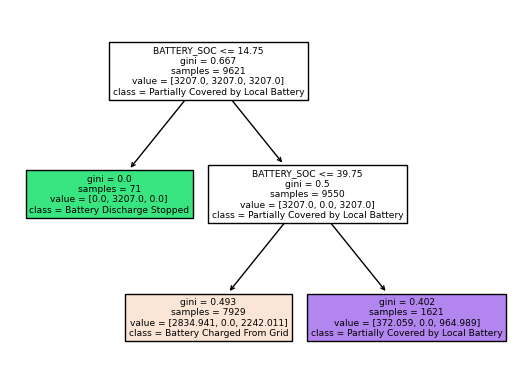

In [23]:
#Fit on the entire dataset
tree.fit(X, y)
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])
# plt.savefig('tree.pdf')

We can again see the battery SOC = 40 threshold.

We can try to estimate how bad the situation is by bootstrapping and checking in how many casses Battery SOC is in one of the nodes.

Percentage of trees where BATTERY_SOC is in at least one of the nodes: 100%. Calculated on 100 bootstrapped trees.


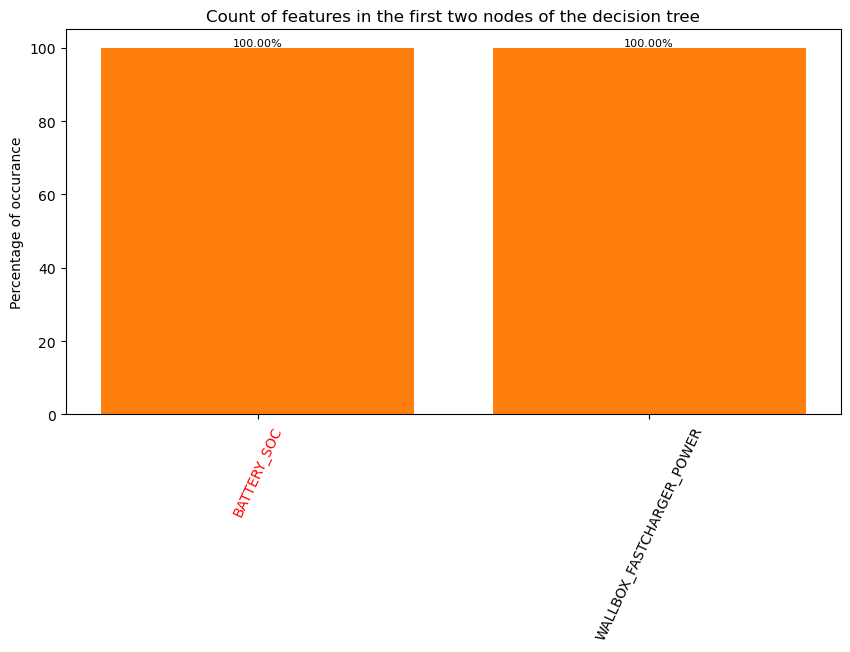

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

n_iterations = 100

features = {}

for _ in range(n_iterations):
    sample = resample(df_GT)
    y = sample['DRAWN_FROM']
    X = sample.drop(DROPPED_COLUMNS, axis=1)
    
    tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
    tree.fit(X, y)
    # sample = sample.drop(DROPPED_COLUMNS, axis=1)
    
        
    # I'm not sure how he features are indexed........
    for feature in X.columns:
        feature_index = X.columns.get_loc(feature)
        if feature_index in tree.tree_.feature and feature_index != -2:
            if feature in features:
                features[feature] += 1
            else:
                features[feature] = 1



features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
percentage_values = [(count / n_iterations) * 100 for count in features.values()]
print(f"Percentage of trees where BATTERY_SOC is in at least one of the nodes: {features['BATTERY_SOC']}%. Calculated on {n_iterations} bootstrapped trees.")
# Plot the dictionary
plt.figure(figsize=(10,5))
bars = plt.bar(features.keys(), percentage_values)
plt.bar(features.keys(), percentage_values)
xtick_labels = features.keys()
for i, label in enumerate(xtick_labels):
    if label == "BATTERY_SOC":
        plt.gca().get_xticklabels()[i].set_color('red')
    else:
        plt.gca().get_xticklabels()[i].set_color('black')
for bar, value in zip(bars, percentage_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=65, fontsize=10)
plt.ylabel('Percentage of occurance')
plt.title('Count of features in the first two nodes of the decision tree')
plt.show()

# Generalization to the Entire Dataset

In [25]:
generalized_df = s_data.copy()
generalized_df["DRAWN_FROM"] = generalized_df.apply(label_charging, axis=1)


In [26]:
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

In [27]:
prediction = tree.predict(generalized_df[['BATTERY_SOC']])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
display(accuracy)

0.13532519094243128

Generalizing the model, based on the ground truth rules results in poor performance. However, performance jumps significantly, if some additional features are considered.

[Text(0.4, 0.8333333333333334, 'BATTERY_SOC <= 14.75\ngini = 0.667\nsamples = 9621\nvalue = [3207.0, 3207.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 71\nvalue = [0.0, 3207.0, 0.0]\nclass = Battery Discharge Stopped'),
 Text(0.6, 0.5, 'BATTERY_SOC <= 39.75\ngini = 0.5\nsamples = 9550\nvalue = [3207.0, 0.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.4, 0.16666666666666666, 'gini = 0.493\nsamples = 7929\nvalue = [2834.941, 0.0, 2242.011]\nclass = Battery Charged From Grid'),
 Text(0.8, 0.16666666666666666, 'gini = 0.402\nsamples = 1621\nvalue = [372.059, 0.0, 964.989]\nclass = Partially Covered by Local Battery')]

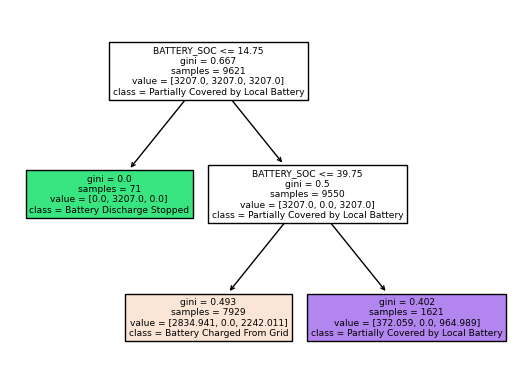

In [28]:
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])

In [29]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

In [30]:
prediction = tree.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
display(accuracy)

0.917987281719996

[Text(0.4, 0.8333333333333334, 'BATTERY_SOC <= 14.75\ngini = 0.667\nsamples = 9621\nvalue = [3207.0, 3207.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 71\nvalue = [0.0, 3207.0, 0.0]\nclass = Battery Discharge Stopped'),
 Text(0.6, 0.5, 'WALLBOX_FASTCHARGER_POWER <= 46.398\ngini = 0.5\nsamples = 9550\nvalue = [3207.0, 0.0, 3207.0]\nclass = Partially Covered by Local Battery'),
 Text(0.4, 0.16666666666666666, 'gini = 0.2\nsamples = 4512\nvalue = [2030.232, 0.0, 257.716]\nclass = Battery Charged From Grid'),
 Text(0.8, 0.16666666666666666, 'gini = 0.408\nsamples = 5038\nvalue = [1176.768, 0.0, 2949.284]\nclass = Partially Covered by Local Battery')]

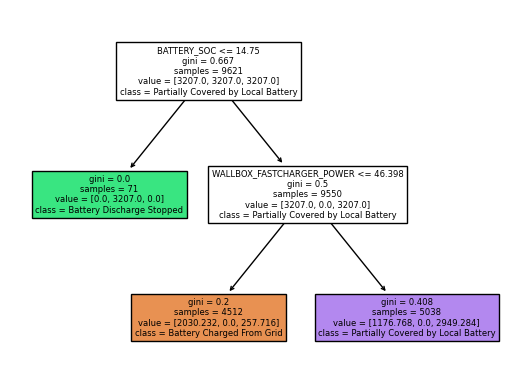

In [31]:
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])

# Neural Network with Local Explainability

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.8662393593755258


In [33]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)

mlp = MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

# Fit the classifier to the training data
mlp.fit(X, y)

# Use the classifier to predict the classes of the test data
predicted_classes = mlp.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))

# Print the accuracy score
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], predicted_classes)
print(f"Neural network accuracy on DROPPED COLUMNS: {accuracy}")

Neural network accuracy on DROPPED COLUMNS: 0.9341543016722182


Neural networks perform significantly better when predictiong solely on BATTERY_SOC. When including fastcharger power, the models perform similarly.

In [34]:
import numpy as np
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

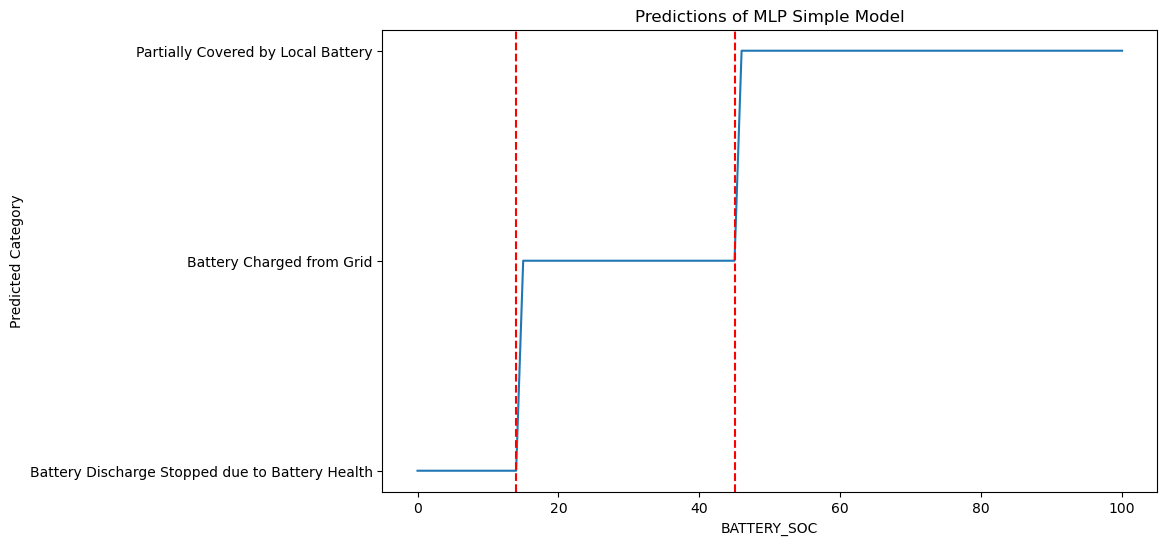

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(X_verify['BATTERY_SOC'], X_verify['PREDICTIONS'], label='Predictions')
plt.axvline(x=14, color="red", linestyle="--")
plt.axvline(x=45, color="red", linestyle="--")
plt.xlabel('BATTERY_SOC')
plt.ylabel('Predicted Category')
plt.title('Predictions of MLP Simple Model')


plt.show()

Why is there such a discrepancy in accuracy? I guess we came up with better rules? We try together with fast charger

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC', "WALLBOX_FASTCHARGER_POWER"]]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC", "WALLBOX_FASTCHARGER_POWER"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.9286699639985195


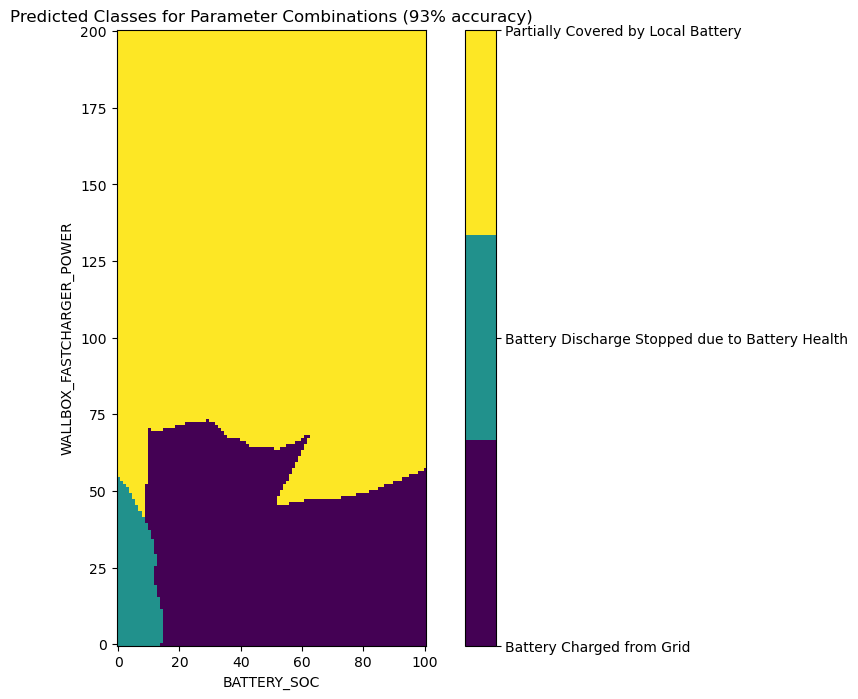

In [37]:
from sklearn.preprocessing import LabelEncoder

# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)

# Flatten the grid and create a DataFrame from it
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})

# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)

# Initialize a LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder and transform the predictions to numerical data
numerical_predictions = le.fit_transform(predictions)

# Reshape the predictions to the shape of the grid
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(['#440154', '#21918c', '#fde725'])  # replace with the colors you want

# Plot the predictions as a heatmap
plt.figure(figsize=(10, 8))
img = plt.imshow(numerical_predictions, cmap=cmap, origin='lower')

# Create a custom colorbar
cbar = plt.colorbar(img, ticks=[0, 1, 2])  # replace with the number of your classes
cbar.ax.set_yticklabels(le.classes_)  # set the labels of the colorbar to the class names

plt.xlabel('BATTERY_SOC')
plt.ylabel('WALLBOX_FASTCHARGER_POWER')
plt.title('Predicted Classes for Parameter Combinations (93% accuracy)')
plt.show()

Can I support my decision to only include wallpower?

## SHAP

In [38]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)

mlp = MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

# Fit the classifier to the training data
mlp.fit(X, y)

# Use the classifier to predict the classes of the test data
predicted_classes = mlp.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))

# Print the accuracy score
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], predicted_classes)
print(f"Neural network accuracy on DROPPED COLUMNS: {accuracy}")

Neural network accuracy on DROPPED COLUMNS: 0.9341543016722182


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


  0%|          | 0/10 [00:00<?, ?it/s]

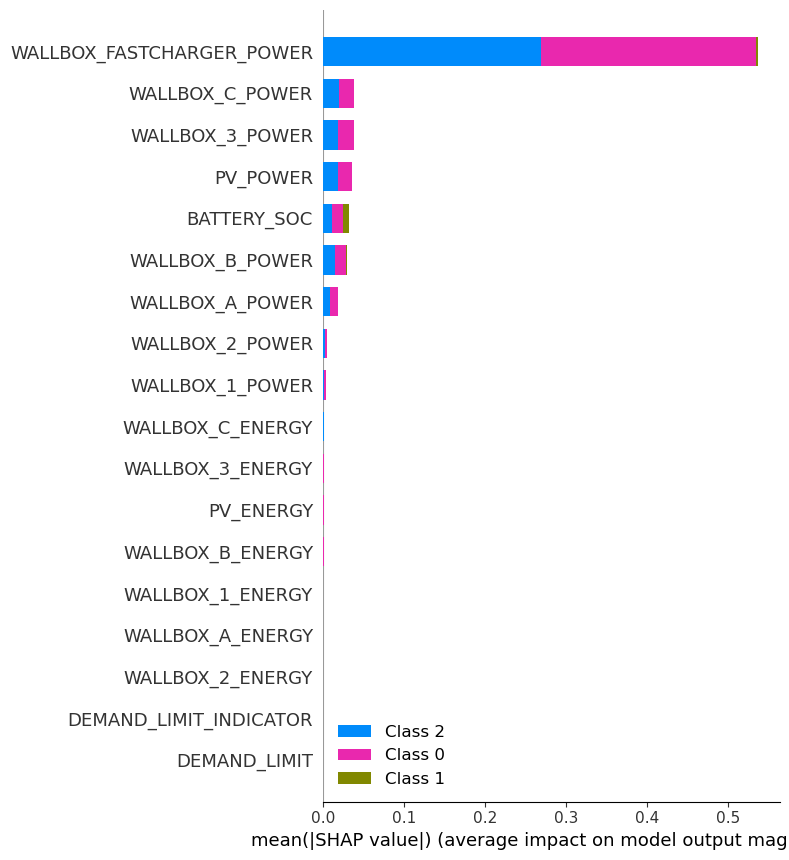

In [39]:
import shap

background_data = shap.sample(X, 100) 
# Create a SHAP explainer
explainer = shap.KernelExplainer(mlp.predict_proba, background_data)

# Compute SHAP values for a sample of the data
shap_values = explainer.shap_values(X.sample(10))

# Plot the SHAP values
shap.summary_plot(shap_values, X.sample(10))

# Dynamic dataset

In [1]:
d_data = pd.read_csv(DATA_PATH + '/Stud_E-mobility_data_dynamicLimit.csv')

NameError: name 'pd' is not defined

In [47]:
d_data["POWER_DEMAND"] = d_data["WALLBOX_1_POWER"] + d_data["WALLBOX_2_POWER"] + d_data["WALLBOX_3_POWER"] + d_data["WALLBOX_A_POWER"] + d_data["WALLBOX_B_POWER"] + d_data["WALLBOX_C_POWER"] + d_data["WALLBOX_FASTCHARGER_POWER"]
d_data["POWER_SUPPLY"] = d_data["GARAGE_EXTERNAL_POWER"] + d_data["PV_POWER"] + d_data["BATTERY_DISCHARGE_POWER"]

In [48]:
d_data['_time'] = pd.to_datetime(d_data['_time'])

In [41]:
d_data["POWER_DEMAND_EXCEEDS_SUPPLY"] = d_data["POWER_DEMAND"] > d_data["POWER_SUPPLY"]
d_data["POWER_EXCEEDS_LIMIT"] = d_data["GARAGE_EXTERNAL_POWER"] > d_data["DEMAND_LIMIT"]
d_data["POWER_EXCEEDS_LIMIT"].value_counts()

POWER_EXCEEDS_LIMIT
False    117543
True       3808
Name: count, dtype: int64

In [9]:
features = d_data.drop(['POWER_EXCEEDS_LIMIT', '_time', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = d_data['POWER_EXCEEDS_LIMIT']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


clf = DecisionTreeClassifier(random_state=42, max_depth=1, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.8674137859997528


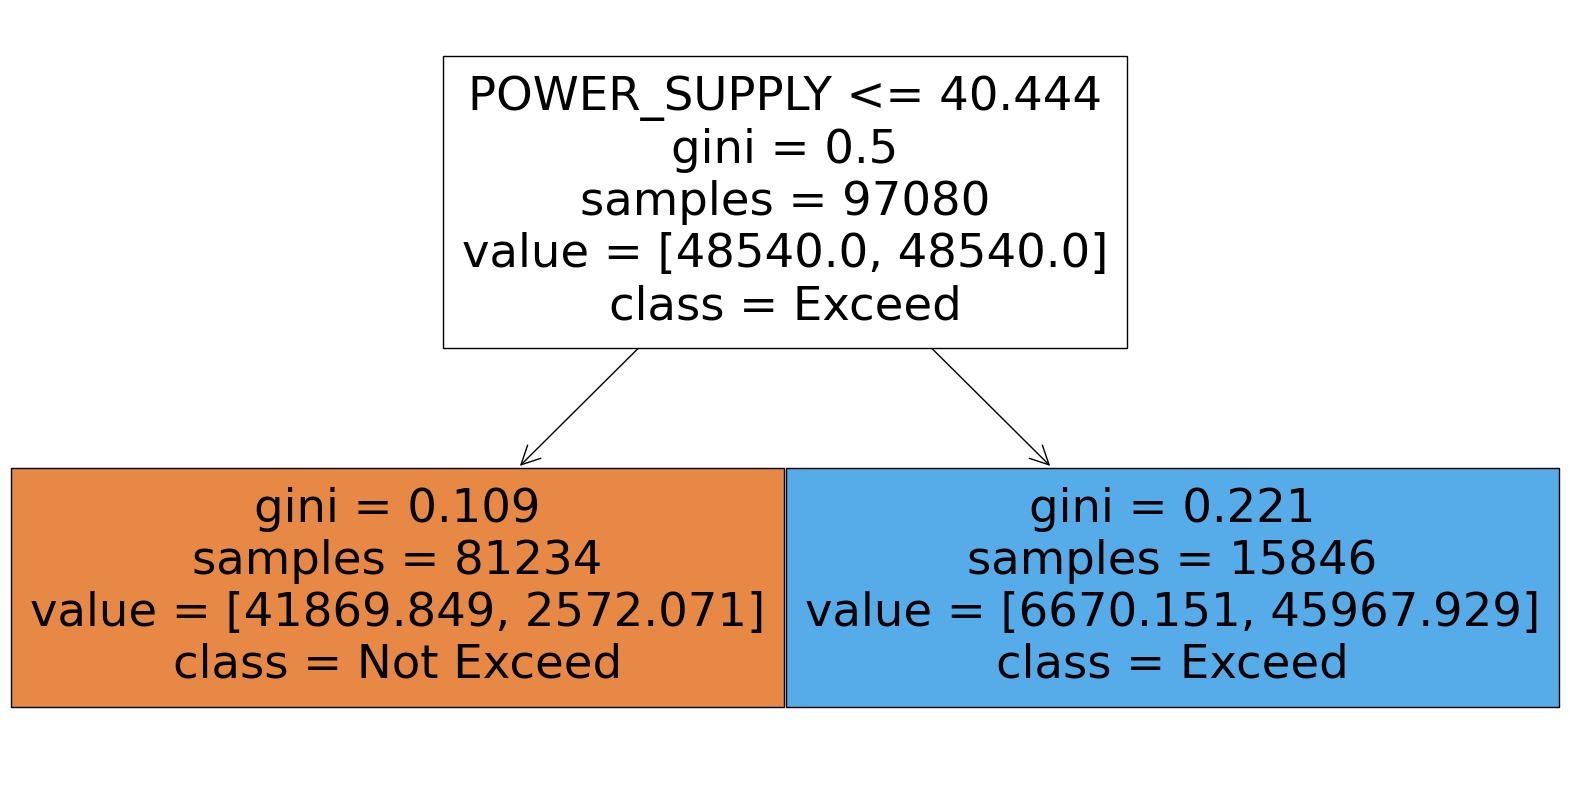

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))  
plot_tree(clf, filled=True, feature_names=features.columns, class_names=['Not Exceed', 'Exceed'])
plt.show()

In [52]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = d_data[(d_data["BATTERY_SOC"]<=15) & (d_data["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = d_data[(d_data["BATTERY_SOC"]>15) &(d_data["BATTERY_SOC"]<40) & (d_data["GARAGE_EXTERNAL_POWER"]<50) & (d_data["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = d_data[(d_data["BATTERY_SOC"]>15) &(d_data["BATTERY_SOC"]<40) & (d_data["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=d_data["GARAGE_EXTERNAL_POWER"]) & (d_data["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = d_data[(d_data["BATTERY_SOC"]>=40) & (d_data["BATTERY_DISCHARGE_POWER"]>=0)]

In [53]:
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(df_GT)/len(s_data)*100}%")

Percentage of dataset, that is kept: 6.429797113152317%


In [54]:
import pandas as pd

# Assuming df_GT is your DataFrame containing the dataset

def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)


In [56]:
DROPPED_COLUMNS = ['DEMAND_LIMIT', 'DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]     #.drop(DROPPED_COLUMNS, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree.fit(X_train, y_train)
accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f"Balanced accuracy: {accuracy}")

Balanced accuracy: 0.6091503267973856


[Text(0.5, 0.8333333333333334, 'BATTERY_SOC <= 39.25\ngini = 0.5\nsamples = 3822\nvalue = [1911.0, 1911.0]\nclass = Battery Discharge Stopped'),
 Text(0.25, 0.5, 'BATTERY_SOC <= 23.0\ngini = 0.328\nsamples = 394\nvalue = [289.066, 75.419]\nclass = Battery Charged From Grid'),
 Text(0.125, 0.16666666666666666, 'gini = 0.5\nsamples = 7\nvalue = [3.514, 3.481]\nclass = Battery Charged From Grid'),
 Text(0.375, 0.16666666666666666, 'gini = 0.321\nsamples = 387\nvalue = [285.552, 71.938]\nclass = Battery Charged From Grid'),
 Text(0.75, 0.5, 'BATTERY_SOC <= 40.25\ngini = 0.498\nsamples = 3428\nvalue = [1621.934, 1835.581]\nclass = Battery Discharge Stopped'),
 Text(0.625, 0.16666666666666666, 'gini = 0.478\nsamples = 1235\nvalue = [502.571, 769.273]\nclass = Battery Discharge Stopped'),
 Text(0.875, 0.16666666666666666, 'gini = 0.5\nsamples = 2193\nvalue = [1119.363, 1066.308]\nclass = Battery Charged From Grid')]

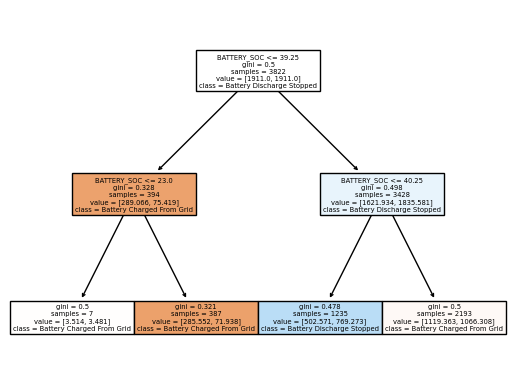

In [57]:
#Fit on the entire dataset
tree.fit(X, y)
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])
# plt.savefig('tree.pdf')

Percentage of trees where BATTERY_SOC is in at least one of the nodes: 10%. Calculated on 100 bootstrapped trees.


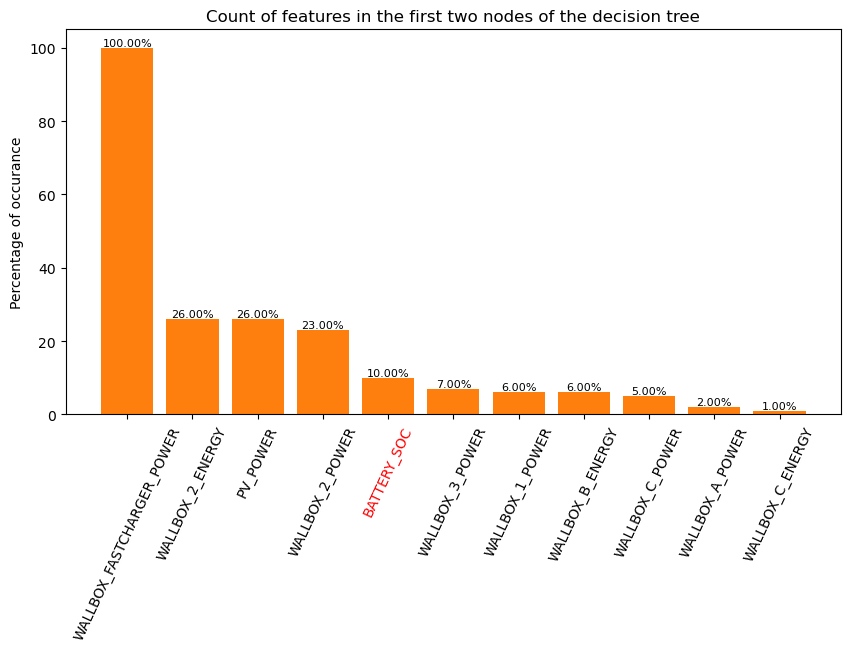

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

n_iterations = 100

features = {}

for _ in range(n_iterations):
    sample = resample(df_GT)
    y = sample['DRAWN_FROM']
    X = sample.drop(DROPPED_COLUMNS, axis=1)
    
    tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced')
    tree.fit(X, y)
    # sample = sample.drop(DROPPED_COLUMNS, axis=1)
    
        
    # I'm not sure how he features are indexed........
    for feature in X.columns:
        feature_index = X.columns.get_loc(feature)
        if feature_index in tree.tree_.feature and feature_index != -2:
            if feature in features:
                features[feature] += 1
            else:
                features[feature] = 1



features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
percentage_values = [(count / n_iterations) * 100 for count in features.values()]
print(f"Percentage of trees where BATTERY_SOC is in at least one of the nodes: {features['BATTERY_SOC']}%. Calculated on {n_iterations} bootstrapped trees.")
# Plot the dictionary
plt.figure(figsize=(10,5))
bars = plt.bar(features.keys(), percentage_values)
plt.bar(features.keys(), percentage_values)
xtick_labels = features.keys()
for i, label in enumerate(xtick_labels):
    if label == "BATTERY_SOC":
        plt.gca().get_xticklabels()[i].set_color('red')
    else:
        plt.gca().get_xticklabels()[i].set_color('black')
for bar, value in zip(bars, percentage_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=65, fontsize=10)
plt.ylabel('Percentage of occurance')
plt.title('Count of features in the first two nodes of the decision tree')
plt.show()

In [22]:
generalized_df = d_data.copy()
generalized_df["DRAWN_FROM"] = generalized_df.apply(label_charging, axis=1)


In [23]:
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

In [24]:
prediction = tree.predict(generalized_df[['BATTERY_SOC']])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
display(accuracy)

0.9653237303359675

[Text(0.5, 0.8333333333333334, 'BATTERY_SOC <= 39.25\ngini = 0.5\nsamples = 3822\nvalue = [1911.0, 1911.0]\nclass = Battery Discharge Stopped'),
 Text(0.25, 0.5, 'BATTERY_SOC <= 23.0\ngini = 0.328\nsamples = 394\nvalue = [289.066, 75.419]\nclass = Battery Charged From Grid'),
 Text(0.125, 0.16666666666666666, 'gini = 0.5\nsamples = 7\nvalue = [3.514, 3.481]\nclass = Battery Charged From Grid'),
 Text(0.375, 0.16666666666666666, 'gini = 0.321\nsamples = 387\nvalue = [285.552, 71.938]\nclass = Battery Charged From Grid'),
 Text(0.75, 0.5, 'BATTERY_SOC <= 40.25\ngini = 0.498\nsamples = 3428\nvalue = [1621.934, 1835.581]\nclass = Battery Discharge Stopped'),
 Text(0.625, 0.16666666666666666, 'gini = 0.478\nsamples = 1235\nvalue = [502.571, 769.273]\nclass = Battery Discharge Stopped'),
 Text(0.875, 0.16666666666666666, 'gini = 0.5\nsamples = 2193\nvalue = [1119.363, 1066.308]\nclass = Battery Charged From Grid')]

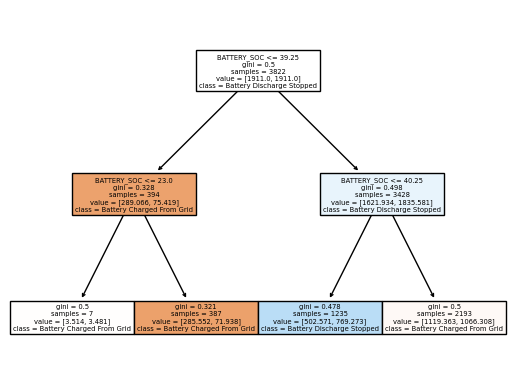

In [25]:
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])

In [26]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)
tree = DecisionTreeClassifier(random_state=42, max_depth=2, class_weight='balanced')
tree.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=42)

In [27]:
prediction = tree.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
display(accuracy)

0.951537276165833

[Text(0.5, 0.8333333333333334, 'WALLBOX_FASTCHARGER_POWER <= 42.145\ngini = 0.5\nsamples = 3822\nvalue = [1911.0, 1911.0]\nclass = Battery Discharge Stopped'),
 Text(0.25, 0.5, 'PV_POWER <= 0.001\ngini = 0.297\nsamples = 495\nvalue = [372.535, 82.381]\nclass = Battery Charged From Grid'),
 Text(0.125, 0.16666666666666666, 'gini = 0.142\nsamples = 235\nvalue = [194.175, 16.244]\nclass = Battery Charged From Grid'),
 Text(0.375, 0.16666666666666666, 'gini = 0.395\nsamples = 260\nvalue = [178.36, 66.137]\nclass = Battery Charged From Grid'),
 Text(0.75, 0.5, 'WALLBOX_FASTCHARGER_POWER <= 78.431\ngini = 0.496\nsamples = 3327\nvalue = [1538.465, 1828.619]\nclass = Battery Discharge Stopped'),
 Text(0.625, 0.16666666666666666, 'gini = 0.499\nsamples = 1612\nvalue = [832.054, 771.594]\nclass = Battery Charged From Grid'),
 Text(0.875, 0.16666666666666666, 'gini = 0.48\nsamples = 1715\nvalue = [706.411, 1057.026]\nclass = Battery Discharge Stopped')]

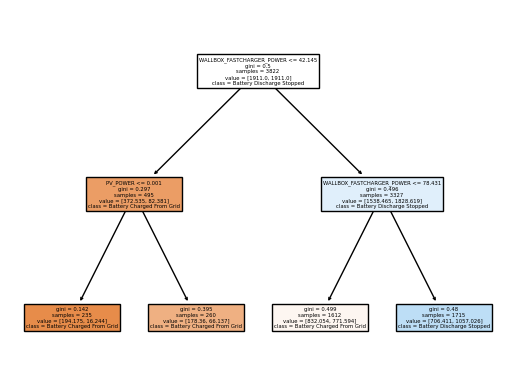

In [28]:
plot_tree(tree, filled=True, feature_names=X.columns, class_names=['Battery Charged From Grid', 'Battery Discharge Stopped', 'Partially Covered by Local Battery'])

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.9686199536880619


In [30]:
y = df_GT['DRAWN_FROM']
X = df_GT.drop(DROPPED_COLUMNS, axis=1)

mlp = MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

# Fit the classifier to the training data
mlp.fit(X, y)

# Use the classifier to predict the classes of the test data
predicted_classes = mlp.predict(generalized_df.drop(DROPPED_COLUMNS, axis=1))

# Print the accuracy score
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], predicted_classes)
print(f"Neural network accuracy on DROPPED COLUMNS: {accuracy}")

Neural network accuracy on DROPPED COLUMNS: 0.944236141440944


In [34]:
import numpy as np
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

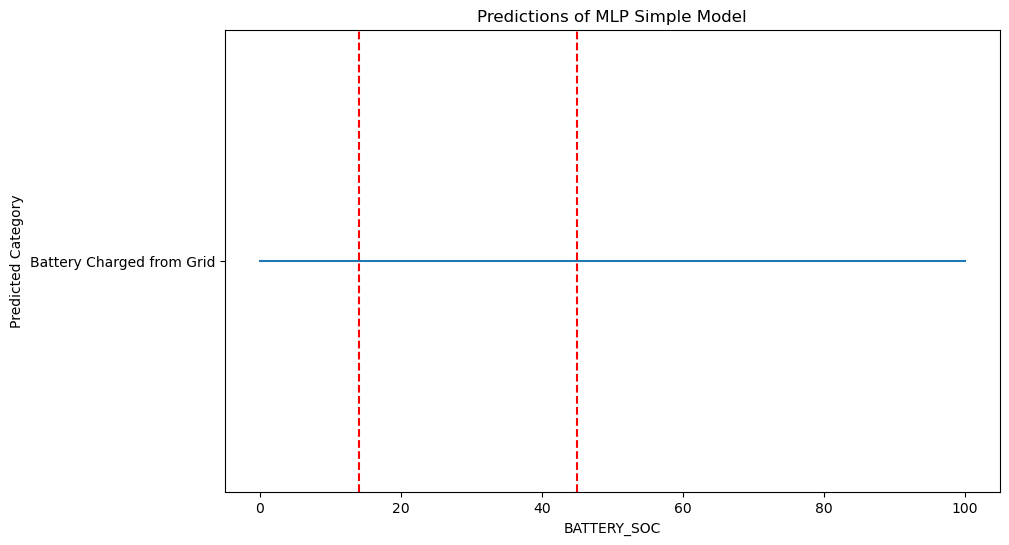

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(X_verify['BATTERY_SOC'], X_verify['PREDICTIONS'], label='Predictions')
plt.axvline(x=14, color="red", linestyle="--")
plt.axvline(x=45, color="red", linestyle="--")
plt.xlabel('BATTERY_SOC')
plt.ylabel('Predicted Category')
plt.title('Predictions of MLP Simple Model')


plt.show()

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC', "WALLBOX_FASTCHARGER_POWER"]]

# Create the MLP classifier
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)

# Fit the classifier to the training data
mlp_simple.fit(X, y)

# Use the classifier to predict the classes of the test data
prediction = mlp_simple.predict(generalized_df[["BATTERY_SOC", "WALLBOX_FASTCHARGER_POWER"]])
accuracy = accuracy_score(generalized_df['DRAWN_FROM'], prediction)
print(f"Neural network accuracy on BATTEY_SOC: {accuracy}")

Neural network accuracy on BATTEY_SOC: 0.9406679796623019


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

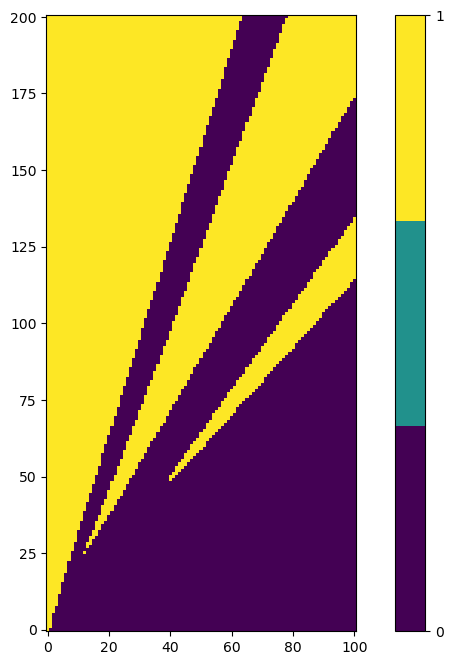

In [37]:
from sklearn.preprocessing import LabelEncoder

# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)

# Flatten the grid and create a DataFrame from it
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})

# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)

# Initialize a LabelEncoder
le = LabelEncoder()
# Fit the LabelEncoder and transform the predictions to numerical data
numerical_predictions = le.fit_transform(predictions)

# Reshape the predictions to the shape of the grid
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)

from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap

# Define the colormap
cmap = ListedColormap(['#440154', '#21918c', '#fde725'])  # replace with the colors you want

# Plot the predictions as a heatmap
plt.figure(figsize=(10, 8))
img = plt.imshow(numerical_predictions, cmap=cmap, origin='lower')

# Create a custom colorbar
cbar = plt.colorbar(img, ticks=[0, 1, 2])  # replace with the number of your classes
cbar.ax.set_yticklabels(le.classes_)  # set the labels of the colorbar to the class names

plt.xlabel('BATTERY_SOC')
plt.ylabel('WALLBOX_FASTCHARGER_POWER')
plt.title('Predicted Classes for Parameter Combinations (93% accuracy)')
plt.show()